<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

**Цель проекта** - построить модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста. Критерием качества модели выступает метрика `MAE `, которая не должна превышать значение 8.

## Исследовательский анализ данных

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import HTML, display
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook

In [2]:
SEED = 12345

display(HTML('<style>.container { width:90% !important; }</style>'))

In [3]:
def get_df(file_name):
    path_to_file = os.path.relpath(
        os.path.join('/datasets/', 'faces', file_name)
    )
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file)
    raise Exception('Данные отсутствуют')

In [4]:
df = get_df('labels.csv')

True


In [5]:
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
6930,006941.jpg,38
4337,004337.jpg,25
4981,004981.jpg,33
2468,002468.jpg,49
3897,003897.jpg,14
1389,001389.jpg,3
5974,005975.jpg,24
137,000137.jpg,52
3721,003721.jpg,19
2262,002262.jpg,32


In [6]:
df.duplicated().sum()

0

In [7]:
def get_histogram(data, col, f_size=(15, 5), bins_num=20, plot_style='-'):
    fig, axs = plt.subplots(2, 1, figsize=(f_size), sharex=True,
                            gridspec_kw={'height_ratios': [3, 1]})
    median = data[col].median()
    mean = data[col].mean()
    ax = axs[0]
    ax.set_title('Распределение возраста')
    sns.histplot(data[col], bins=bins_num, ax=ax, edgecolor='white',
                 label='Распределение возраста', kde=True)
    
    ax.axvline(x=median, c='r',
               label=f'Медиана: {median:.0f}')
    ax.axvline(x=mean, c='r', ls='--',
               label=f'Среднее: {mean:.0f}')

    ax.legend(loc='upper right')
    ax.set_ylabel('Количество')
    ax.grid(True)

    red_circle = dict(markerfacecolor='red', marker='o',
                      markeredgecolor='white')
    ax = axs[1]
    data[col].plot.box(flierprops=red_circle, ax=ax, vert=False)
    ax.grid(True)
    ax.set_yticks([])
    ax.set_xlabel('Возраст')
    plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


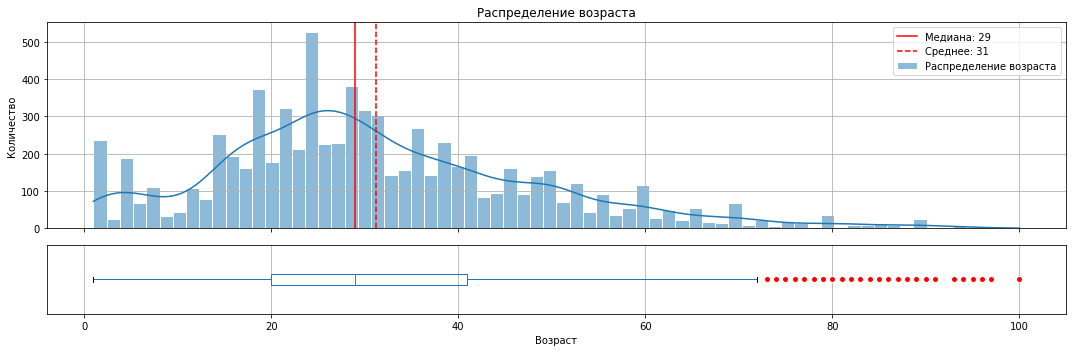

In [8]:
get_histogram(df, 'real_age', bins_num=70)
df[['real_age']].describe().T

0it [00:00, ?it/s]

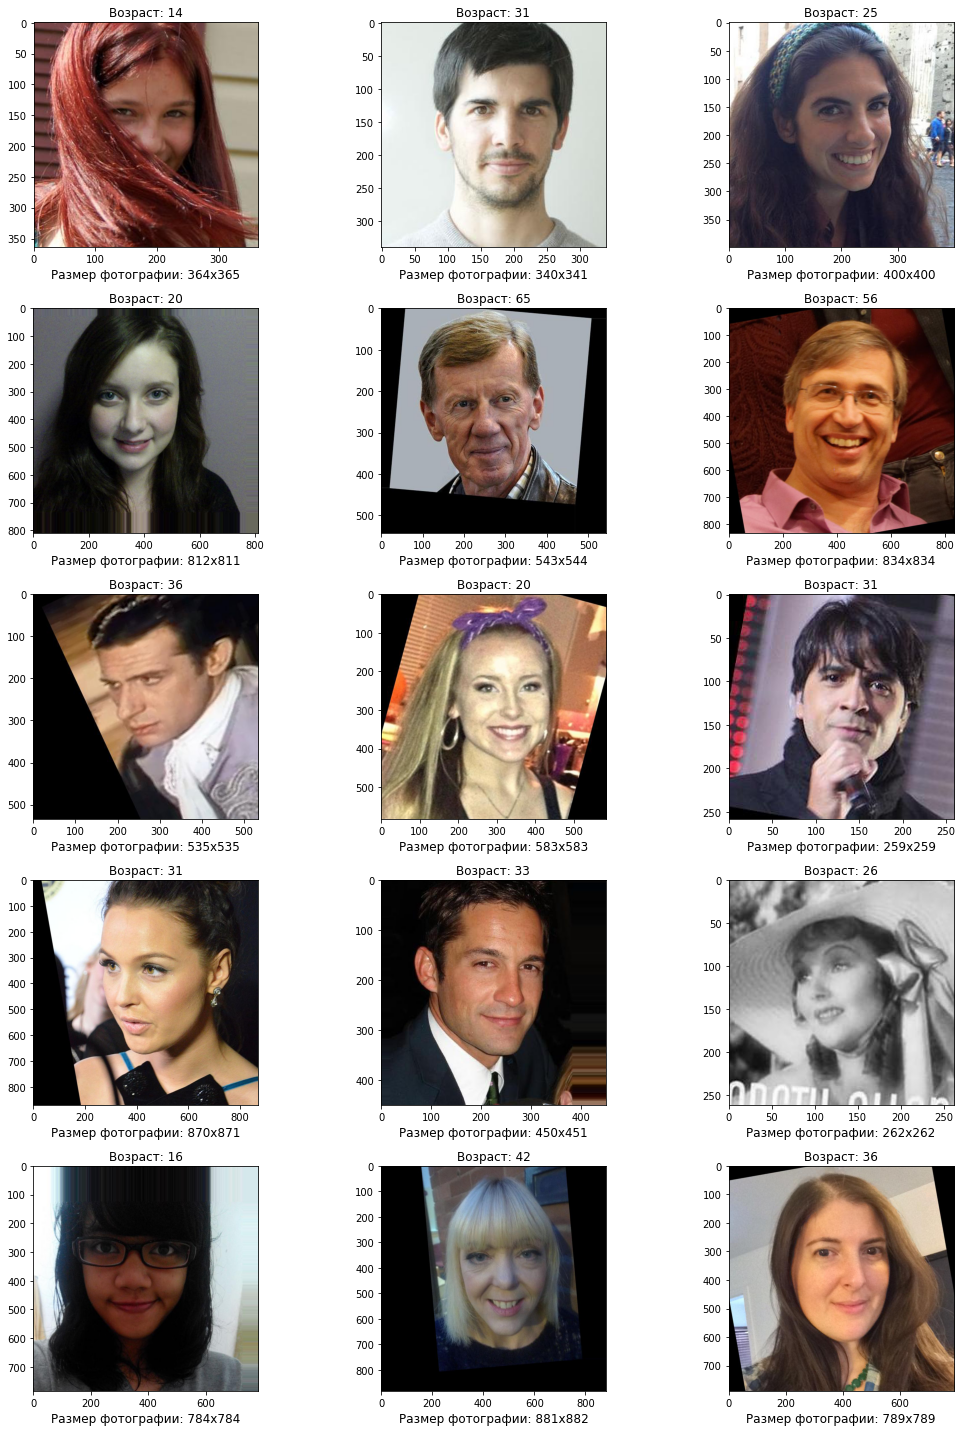

In [9]:
images_dir = '/datasets/faces/final_files/'

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
items = df.sample(15).values
for item, ax in notebook.tqdm(zip(items, axs.flat)):
    file_name, age = item
    local_image = Image.open(images_dir + file_name)
    img_width, img_height = local_image.size
    ax.imshow(local_image)
    ax.set_title(f'Возраст: {age}', fontsize=12)
    ax.set_xlabel(f'Размер фотографии: {img_width}x{img_height}',
                  fontsize=12)
plt.tight_layout()

**Вывод**:  
- загруженный набор данных состоит из 7591-го объекта;  
- пропуски, явные дубликаты и аномальные значения отсутствуют;  
- основная доля объектов – фотографии людей возрастом моложе 70-ти лет;  
- в датасете присутствует значительное количество фотографий детей младше 6-ти лет;  
- особенности данных, которые, вероятно, осложнят обучение модели:  
    - часть объектов в датасете не являются фотографиями человека;  
    - в наборе данных содержатся как фотографии лиц, так и человека в полный рост;
    - на некоторых фотографиях присутствуют предметы, частично скрывающие лицо;    
    - фотографии лиц сделаны под разными углами;  
    - присутствуют как цветные, так и чёрно-белые изображения;  
    - изображения отличаются размером, качеством, уровнем яркости и углом наклона.

## Обучение модели

In [10]:
# def load_train(path):
#     datagen = ImageDataGenerator(
#         validation_split=0.25,
#         rescale=1./255,
#         horizontal_flip=True,
#         height_shift_range=0.2,
#         shear_range=0.3
#     )
#     train_datagen_flow = datagen.flow_from_dataframe(
#         pd.read_csv(path + 'labels.csv'),
#         path + 'final_files/',
#         x_col='file_name',
#         y_col='real_age',
#         class_mode='raw',
#         subset='training',
#         seed=SEED
#     )
#     return train_datagen_flow


# def load_test(path):
#     datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
#     test_datagen_flow = datagen.flow_from_dataframe(
#         pd.read_csv(path + 'labels.csv'),
#         path + 'final_files/',
#         x_col='file_name',
#         y_col='real_age',
#         class_mode='raw',
#         subset='validation',
#         seed=SEED
#     )
#     return test_datagen_flow


# def create_model(input_shape):
#     backbone = ResNet50(input_shape=input_shape, weights='imagenet',
#                         include_top=False) 
#     model = Sequential()
#     model.add(backbone)
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
#     model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])
#     return model


# def train_model(model, train_data, test_data, batch_size=None, epochs=15,
#                 steps_per_epoch=None, validation_steps=None):
#     model.fit(train_data,
#               validation_data=test_data,
#               batch_size=batch_size, epochs=epochs,
#               steps_per_epoch=steps_per_epoch,
#               validation_steps=validation_steps,
#               verbose=2)
#     return model

**Результат вывода модели на экран**

Train for 178 steps, validate for 60 steps
Epoch 1/20  
178/178 - 119s - loss: 245.3611 - mae: 11.2559 - val_loss: 866.1715 - val_mae: 24.5557  
Epoch 2/20  
178/178 - 112s - loss: 87.0833 - mae: 7.0842 - val_loss: 706.3165 - val_mae: 21.3689  
Epoch 3/20  
178/178 - 108s - loss: 65.1179 - mae: 6.1800 - val_loss: 253.7457 - val_mae: 11.7742  
Epoch 4/20  
178/178 - 107s - loss: 49.0649 - mae: 5.3424 - val_loss: 114.7879 - val_mae: 8.4125  
Epoch 5/20  
178/178 - 106s - loss: 40.5731 - mae: 4.9275 - val_loss: 83.8981 - val_mae: 6.8839  
Epoch 6/20  
178/178 - 106s - loss: 34.1465 - mae: 4.4748 - val_loss: 101.4042 - val_mae: 7.6756  
Epoch 7/20  
178/178 - 106s - loss: 29.1874 - mae: 4.1637 - val_loss: 96.2531 - val_mae: 7.4471  
Epoch 8/20  
178/178 - 106s - loss: 23.9686 - mae: 3.8077 - val_loss: 62.4712 - val_mae: 5.8852  
Epoch 9/20  
178/178 - 106s - loss: 21.8170 - mae: 3.6076 - val_loss: 68.3274 - val_mae: 6.2210  
Epoch 10/20  
178/178 - 106s - loss: 19.4493 - mae: 3.4061 - val_loss: 60.1239 - val_mae: 5.7556  
Epoch 11/20  
178/178 - 106s - loss: 17.1112 - mae: 3.1548 - val_loss: 83.6741 - val_mae: 6.8698  
Epoch 12/20  
178/178 - 106s - loss: 14.9415 - mae: 2.9704 - val_loss: 57.0943 - val_mae: 5.6465  
Epoch 13/20  
178/178 - 106s - loss: 14.8562 - mae: 2.9282 - val_loss: 63.7813 - val_mae: 5.9379  
Epoch 14/20  
178/178 - 106s - loss: 13.0060 - mae: 2.7920 - val_loss: 70.2915 - val_mae: 6.2774  
Epoch 15/20  
178/178 - 106s - loss: 12.5074 - mae: 2.7194 - val_loss: 60.2345 - val_mae: 5.8816  
Epoch 16/20  
178/178 - 109s - loss: 11.2350 - mae: 2.5720 - val_loss: 61.2378 - val_mae: 5.8659  
Epoch 17/20  
178/178 - 106s - loss: 11.1128 - mae: 2.5608 - val_loss: 66.3183 - val_mae: 5.9946  
Epoch 18/20  
178/178 - 106s - loss: 10.9835 - mae: 2.5102 - val_loss: 58.5543 - val_mae: 5.7662  
Epoch 19/20  
178/178 - 106s - loss: 11.0960 - mae: 2.5018 - val_loss: 63.5067 - val_mae: 5.9251  
Epoch 20/20  
178/178 - 106s - loss: 8.9963 - mae: 2.3154 - val_loss: 57.6688 - val_mae: 5.6082  
60/60 - 10s - loss: 57.6688 - mae: 5.6082  
Test MAE: 5.6082

## Анализ обученной модели

Для аугментации данных были заданы параметры `horizontal_flip`, `height_shift_range`, `shear_range` класса `ImageDataGenerator`.</br>  
Для построения модели использовалась архитектура `ResNet50`, при обучении применялся алгоритм `Adam` (скорость обучения равна 0.0001), в качестве функции активации на последнем слое - `LeakyReLU`.</br>  
Значение метрики `MAE ` на тестовой выборке равно 5.6, что удовлетворяет требованию заказчика к качеству модели,  
но, вероятно, недостаточно для контроля возраста клиента при продаже алкоголя.